In [1]:
import os
from datetime import datetime, timedelta
from geopandas import GeoDataFrame
import geopandas as gpd
import gpd_lite_toolbox as glt
import pointpats.quadrat_statistics as qs
from pointpats import PointPattern
import pysal as ps
import shapely.speedups
import pandas as pd
from sklearn.cluster import DBSCAN, OPTICS
import shapely.geometry
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import contextily as ctx
import zipfile


plt.rcParams["font.family"] = "Times New Roman"
shapely.speedups.enable()
warnings.filterwarnings('ignore')
%matplotlib inline

/Users/GeorgePyne/anaconda3/envs/spatiotemporal/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [87]:
plt.rcParams["figure.figsize"] = [6.0, 6.0]

In [3]:
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

In [4]:
def pip_count(points, polygon):
    try : 
        pips = points.within(polygon).value_counts()[True]
    except:
        pips = 0
    
    return pips

# Data Prep

In [ ]:
zf = '/Users/GeorgePyne/Documents/CASA/Digital Visualisation/Group Project/Foursquare_Data.zip'
csvs = [i for i in zipfile.ZipFile(zf).namelist() if str(i).endswith('csv')]
with zipfile.ZipFile(zf) as zipf:
    with zipf.open(csvs[0]) as myZip:
        df = pd.read_csv(myZip)

In [16]:
headers = ["User ID","Venue ID","Venue category ID","Venue category name","Latitude","Longitude","Timezone","UTC time"]
zf = '/Users/GeorgePyne/Downloads/dataset_tsmc2014.zip'
csvs = [i for i in zipfile.ZipFile(zf).namelist() if str(i).endswith('txt')]
with zipfile.ZipFile(zf) as zipf:
    with zipf.open(csvs[0]) as myZip:
        ny = pd.read_csv(myZip, encoding = "ISO-8859-1", names=headers, sep='\t')
        ny["UTC time"] = pd.to_datetime(ny["UTC time"])
    with zipf.open(csvs[2]) as myZip:
        tk = pd.read_csv(myZip, encoding = "ISO-8859-1", names=headers, sep='\t')
        tk["UTC time"] = pd.to_datetime(tk["UTC time"])

In [19]:
ny.tail(5)

,User ID,Venue ID,Venue category ID,Venue category name,Latitude,Longitude,Timezone,UTC time
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-03 18:00:09+00:00
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,40.606800,-74.044170,-240,2012-04-03 18:00:25+00:00
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,2012-04-03 18:02:24+00:00
3,395,4bc7086715a7ef3bef9878da,4bf58dd8d48988d104941735,Medical Center,40.745164,-73.982519,-240,2012-04-03 18:02:41+00:00
4,87,4cf2c5321d18a143951b5cec,4bf58dd8d48988d1cb941735,Food Truck,40.740104,-73.989658,-240,2012-04-03 18:03:00+00:00


In [24]:
tk.groupby('Venue category name').count().sort_values(by='User ID', ascending=False).head(20)[['User ID']]

,User ID
Venue category name,
Train Station,200428
Subway,41666
Ramen / Noodle House,17303
Convenience Store,16833
Japanese Restaurant,15680
Bar,14940
Food & Drink Shop,14023
Electronics Store,10897
Mall,10839


In [26]:
ny.groupby('Venue category name').count().sort_values(by='User ID', ascending=False).head(20)[['User ID']]

,User ID
Venue category name,
Bar,15978
Home (private),15382
Office,12740
Subway,9348
Gym / Fitness Center,9171
Coffee Shop,7510
Food & Drink Shop,6596
Train Station,6408
Park,4804


In [35]:
ny['geometry'] = [shapely.geometry.Point(lat,lon) for lat,lon in zip(ny.Latitude,ny.Longitude)]
# pd.to_datetime(uk.datetime)
ny = GeoDataFrame(ny)
ny.crs = {'init': 'epsg:4326'}
ny = ny.to_crs(epsg=2263)
ny.Latitude,ny.Longitude = ny.geometry.y, ny.geometry.x

,User ID,Venue ID,Venue category ID,Venue category name,Latitude,Longitude,Timezone,UTC time,geometry
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,-1.293045e+07,1.409679e+08,-240,2012-04-03 18:00:09+00:00,POINT (140967850.9133387 -12930447.60103067)
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,-1.317588e+07,1.411609e+08,-240,2012-04-03 18:00:25+00:00,POINT (141160926.7219431 -13175881.49168139)
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),-1.275225e+07,1.402779e+08,-240,2012-04-03 18:02:24+00:00,POINT (140277876.0796998 -12752252.747057)
3,395,4bc7086715a7ef3bef9878da,4bf58dd8d48988d104941735,Medical Center,-1.285892e+07,1.408625e+08,-240,2012-04-03 18:02:41+00:00,POINT (140862512.2161338 -12858919.53846596)
4,87,4cf2c5321d18a143951b5cec,4bf58dd8d48988d1cb941735,Food Truck,-1.287803e+07,1.409017e+08,-240,2012-04-03 18:03:00+00:00,POINT (140901665.5565138 -12878030.35724585)
5,484,4b5b981bf964a520900929e3,4bf58dd8d48988d118951735,Food & Drink Shop,-1.290330e+07,1.406784e+08,-240,2012-04-03 18:04:00+00:00,POINT (140678422.8359381 -12903301.66054809)
6,642,4ab966c3f964a5203c7f20e3,4bf58dd8d48988d1e0931735,Coffee Shop,-1.283570e+07,1.408167e+08,-240,2012-04-03 18:04:38+00:00,POINT (140816700.3870497 -12835697.95476328)
7,292,4d0cc47f903d37041864bf55,4bf58dd8d48988d12b951735,Bus Station,-1.276237e+07,1.407201e+08,-240,2012-04-03 18:04:42+00:00,POINT (140720108.440567 -12762365.87777294)
8,428,4ce1863bc4f6a35d8bd2db6c,4bf58dd8d48988d103941735,Home (private),-1.314318e+07,1.411181e+08,-240,2012-04-03 18:06:18+00:00,POINT (141118065.7302082 -13143182.00464698)
9,877,4be319b321d5a59352311811,4bf58dd8d48988d10a951735,Bank,-1.307253e+07,1.408540e+08,-240,2012-04-03 18:06:19+00:00,POINT (140854027.1833139 -13072534.97812957)


In [21]:
base = ny['UTC time'][0]
ny['time'] = ny['UTC time'] - base
ny = ny.sort_values(by='time')
ny['time'] = ny['time'].apply(lambda x: (x.total_seconds() / 60)).astype(int)
# ny

In [43]:
def decomp_preperation(df):
    """Prepares the data for ST decomposition in XYT format"""
    filename = input('Filename? ')
    directory = "/Users/GeorgePyne/Documents/CASA/Dissertation/IPYNB/decompSpaceTime-master/files/"+filename
    
    df[['Longitude','Latitude','time']].to_csv(directory,header=False,index=False)
    xmin, xmax = df.Longitude.min(), df.Longitude.max() 
    ymin, ymax = df.Latitude.min(), df.Latitude.max()
    zmin, zmax = df.time.min(), df.time.max()
        
    src = open(directory,"r")
    fline = '{0},{1},{2},{3},{4},{5}\n'.format(xmin,xmax,ymin,ymax,zmin,zmax)
    oline = src.readlines()
    oline.insert(0,fline)
    src.close()
    
    src=open(directory,"w")
    src.writelines(oline)
    src.close()

In [44]:
decomp_preperation(ny)

Filename? data_nyc.txt


# Spatiotemporal Decomposition

In [ ]:
#import modules
from datetime import datetime
import sys, os
import decomposition as decomp, settings as sett
import geopandas as gpd
import pandas as pd
import shapely
from shapely import geometry
import shutil

#set recursion limit
sys.setrecursionlimit(8000)

#initialize global variables
sett.init()
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#read parameters
pFile = open('files/parameterFile.txt', "r")
pFile.readline()
pList = pFile.readline().split("\t")

sett.p1 = float(pList[0])	# p1 = spatial bandwidth
sett.p2 = float(pList[1])	# p2 = temporal bandwidth
sett.p3 = float(pList[2])	# p3 = spatial resolution
sett.p4 = float(pList[3])	# p4 = temporal resolution
sett.p5 = float(pList[4])	# p5 = number of points threshold (T1)
sett.p6 = float(pList[5])	# p6 = buffer ratio threshold (T2)
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#create output directory
sett.dir1 = 'pointFiles'
sett.dir2 = 'timeFiles'
sett.dir3 = 'shpFiles'

if os.path.exists(sett.dir1):
    shutil.rmtree(sett.dir1)
os.makedirs(sett.dir1)

if os.path.exists(sett.dir2):
    shutil.rmtree(sett.dir2)
os.makedirs(sett.dir2)

if os.path.exists(sett.dir3):
    shutil.rmtree(sett.dir3)
os.makedirs(sett.dir3)
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#read input point file
pFile = open('files/decomp_test_prep.txt', "r")
inX, inY, inZ = [], [], []
r = pFile.readline().split(",")
xmin, xmax, ymin, ymax, zmin, zmax = float(r[0]), float(r[1]), float(r[2]), float(r[3]), float(r[4]), float(r[5].strip())

for record in pFile:   
    inX.append(float(record.split(",")[0]))
    inY.append(float(record.split(",")[1]))
    inZ.append(float(record.split(",")[2]))
    
pFile.close()
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#start decomposition
startTime = datetime.now()
decomp.decompose(inX, inY, inZ, xmin, xmax, ymin, ymax, zmin, zmax)
endTime = datetime.now()

#record decomposition time
runTime = endTime - startTime 
print("Decomposition into {0} files in {1}.".format(len(os.listdir('pointFiles')), runTime))
tFile=open('timeFiles/decomp_time.txt', "w")
tFile.write(str(runTime))
tFile.close()
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Methodology

### Add a var = 1 so that gpd_lite_toolbox aggregates without arbitrary PIP counts

In [94]:
moving_cluster_nps

[7,
 8,
 5,
 9,
 4,
 4,
 4,
 4,
 9,
 4,
 5,
 4,
 4,
 4,
 7,
 6,
 6,
 5,
 6,
 8,
 11,
 6,
 10,
 4,
 5,
 4,
 5,
 8,
 6,
 9,
 5,
 5,
 5,
 8,
 4,
 8,
 4,
 4,
 6,
 4,
 4,
 9,
 4,
 4,
 6,
 6,
 4,
 5,
 10,
 4,
 8,
 8,
 8,
 5,
 7,
 8,
 6,
 4,
 6,
 8,
 6,
 5,
 5,
 6,
 8,
 5,
 5,
 8,
 4,
 6,
 5,
 7,
 5,
 8,
 4,
 6,
 9,
 10,
 10,
 4,
 4,
 5,
 4,
 4,
 5,
 7,
 14,
 7,
 8,
 9,
 8,
 6,
 8,
 4,
 4,
 6,
 4,
 9,
 4,
 5,
 8,
 5,
 10,
 4,
 6,
 8,
 4,
 4,
 4,
 5,
 8,
 5,
 6,
 4,
 5,
 6,
 7,
 6,
 7,
 4,
 4,
 4,
 4,
 7,
 5,
 8,
 8,
 6,
 6,
 4,
 6,
 5,
 5,
 5,
 10,
 4,
 6,
 6,
 4,
 5,
 6,
 4,
 6,
 4,
 7,
 5,
 5,
 5,
 5,
 4,
 5,
 5,
 6,
 6,
 4,
 4,
 5,
 5,
 5,
 5,
 4,
 4,
 5,
 6,
 4,
 6,
 4,
 5,
 6,
 5,
 6,
 7,
 8,
 4,
 7,
 8,
 5,
 4,
 4,
 5,
 5,
 9,
 5,
 5,
 4,
 5,
 4,
 4,
 7,
 4,
 4,
 7,
 10,
 9,
 4,
 5,
 4,
 5,
 7,
 8,
 8,
 10,
 5,
 4,
 4,
 6,
 5,
 4,
 4,
 5,
 5,
 7,
 4,
 4,
 8,
 5,
 6,
 5,
 5,
 7,
 4,
 8,
 4,
 6,
 7,
 4,
 5,
 5,
 5,
 6,
 4,
 5,
 4,
 4,
 5,
 5,
 8,
 8,
 6,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4

In [67]:
cluster_spots, cluster_time = [],[]
static_frames, moving_frames = [], []
static_frames_t, moving_frames_t = [], []
lm_list = []
lm_moves_list = []
# txts = []
times = []
moving_frame_t = []
moving_cluster_nps = []

directory = '/Users/GeorgePyne/Documents/CASA/Dissertation/IPYNB/decompSpaceTime-master/pointFilesworking9Jun/'


for filename in os.listdir(directory): # Iterate over each decomposition domain
# for filename in ['pts_3.txt','pts_4.txt','pts_5.txt']:
    txt = pd.read_csv(directory+'/'+filename, skiprows=1, names=['lon','lat','time']) # read decomp
#     txts.append(txt)
    points = [[lat,lon] for lat,lon in zip(txt.lat, txt.lon)] # Save point patter to test global CSR
    pp = PointPattern(points) # Create point pattern object
    domain_quadrat = qs.QStatistic(pp, shape= "rectangle", nx = 6, ny = 7) # Run quadrat analysis on point pattern object
#     domain_quadrat.plot()
    pv = float(str(domain_quadrat.chi2_pvalue)[0:4])
    if pv < 1.0: # If not CSR and if statistically significant
        start_time = datetime.now() # Time subdomain process
        
        frames = []
        counts = []

        # Create geo_df of points to rasterize
        points_gdf = GeoDataFrame([shapely.geometry.Point(point) for point in points]).rename(columns={0:'geometry'})
        xmin,ymin,xmax,ymax = points_gdf.total_bounds # Get point bounds
        height = (xmax-xmin)/ 6 # Set grid resolution
        grid = glt.make_grid(points_gdf,height, False) # Create unclipped grid   
        
        
        for t in txt.time.unique(): # Iterate over each frame
            frame = txt.loc[txt.time == t] # create frame of each time step
            points = [[lat,lon] for lat,lon in zip(frame.lat, frame.lon)] # make list of points
            frame['geometry'] = [shapely.geometry.Point(point) for point in points] # make point df
            frame = GeoDataFrame(frame) # change to gdf
            frames.append(frame)
            grid[str(int(t))+'_count'] = grid.geometry.apply(lambda x: pip_count(frame,x)) # Aggregate points to grid

        W = ps.weights.Queen.from_dataframe(grid) # Calculate spatial Queen contiguity weights object from grid gdf 
        tci = np.array(grid[grid.columns[1:]]) # Save transitions as matrix
        lm = ps.LISA_Markov(tci,W) # Calculate LISA markov transitions from W and matrix
        lm_list.append(lm)
        
        # creat a LISA transition df of observed against expected
        lm_moves = pd.DataFrame({"Transitions":lm.transitions.flatten(), "Expected":lm.expected_t.flatten()}) 
        lm_moves['Transitions'] = lm_moves['Transitions'].astype(int)
        lm_moves.index = ["HH-HH","HH-LH","HH-LL","HH-HL", # Make index 16 possible move types
                  "LH-HH","LH-LH","LH-LL","LH-HL",
                  "LL-HH","LL-LH","LL-LL","LL-HL",
                  "HL-HH","HL-LH","HL-LL","HL-HL"]
        lm_moves['Residuals'] = lm_moves.Transitions - lm_moves.Expected # Calculate difference of observed - expected
        lm_moves_list.append(lm_moves)
    
        if lm.chi_2[1] < 0.05:
            for frame in frames:                
                if len(frame)>2:
                    points = [[lat,lon] for lat,lon in zip(frame.lat, frame.lon)]
                    pp_t = PointPattern(points)
                    q_h_t = qs.QStatistic(pp,shape= "rectangle",nx = 6, ny = 7)
                    pv_t = float(str(q_h_t.chi2_pvalue)[0:4])
                    if pv_t < 1.0:
                        eps = pp_t.mean_nnd            
                        min_samples = int(len(frame) / 6)
                    if min_samples < 4:
                        min_samples = 4
                    labels = OPTICS(eps=eps, min_samples=min_samples).fit(points).labels_
                    frame['labels'] = labels
                    try:
                        for i in frame.labels.unique():
                            if i > -1:
                                if len(frame.loc[frame['labels']==i]) > 3:
                                    geom = frame.loc[frame['labels']==i]
                                    moving_cluster_nps.append(len(geom))
                                    moving_frames.append\
                                    (shapely.geometry.MultiPoint\
                                     ([shapely.geometry.Point(lat,lon)\
                                       for lat,lon in zip(geom.lon,\
                                                          geom.lat)]).convex_hull)
                                    moving_frame_t.append(frame.time.unique()[0])
                                    end_time = datetime.now() # Save endtime
                                    run_time = end_time - start_time # Find runtime to adjudge parallelization
                                    times.append(run_time)
                    except:
                        print(frame.head(4))
                        
        else:
            for frame in frames:  
                if len(frame)>4:
                    points = [[lat,lon] for lat,lon in zip(frame.lat, frame.lon)]
                    pp_t = PointPattern(points)
                    q_h_t = qs.QStatistic(pp,shape= "rectangle",nx = 6, ny = 7)
                    pv_t = float(str(q_h_t.chi2_pvalue)[0:4])
                    if pv_t < 1.0:
                        eps = pp_t.mean_nnd            
                        min_samples = int(len(frame) / 6)
                    if min_samples < 3:
                        min_samples = 3
                    labels = OPTICS(eps=eps, min_samples=min_samples).fit(points).labels_
                    frame['labels'] = labels
                    try:                        
                        for i in frame.labels.unique():                            
                            if i > -1:
                                if len(frame.loc[frame['labels']==i]) > 3:
                                    geom = frame.loc[frame['labels']==i]
                                    moving_cluster_nps.append(len(geom))
                                    static_frames.append(shapely.geometry.MultiPoint([shapely.geometry.Point(lat,lon) for lat,lon in zip(geom.lon, geom.lat)]).convex_hull)
                                    static_frames_t.append(frame.time.unique()[0])
                                    end_time = datetime.now() # Save endtime
                                    run_time = end_time - start_time # Find runtime to adjudge parallelization
                                    times.append(run_time)
                    except:
                        print(frame.head(4))
                
        end_time = datetime.now()
        run_time = end_time - start_time
        times.append(run_time)
    else:
        print("CSR expected in {}.".format(filename))

CSR expected in pts_951.txt.
CSR expected in pts_372.txt.
CSR expected in pts_373.txt.
CSR expected in pts_617.txt.
CSR expected in pts_165.txt.
CSR expected in pts_950.txt.
CSR expected in pts_21.txt.
CSR expected in pts_23.txt.
CSR expected in pts_37.txt.
CSR expected in pts_173.txt.
CSR expected in pts_629.txt.
CSR expected in pts_371.txt.
CSR expected in pts_359.txt.
CSR expected in pts_199.txt.
CSR expected in pts_947.txt.
CSR expected in pts_36.txt.
CSR expected in pts_200.txt.
CSR expected in pts_943.txt.
CSR expected in pts_348.txt.
CSR expected in pts_360.txt.
CSR expected in pts_361.txt.
CSR expected in pts_375.txt.
CSR expected in pts_349.txt.
CSR expected in pts_163.txt.
CSR expected in pts_605.txt.
CSR expected in pts_201.txt.
CSR expected in pts_25.txt.
CSR expected in pts_149.txt.
CSR expected in pts_175.txt.
CSR expected in pts_388.txt.
CSR expected in pts_377.txt.
CSR expected in pts_376.txt.
CSR expected in pts_389.txt.
CSR expected in pts_148.txt.
CSR expected in pts

In [ ]:
for key, value in index:
    if len(value) > 1:
        index[key] = [shapely.Multipolygon(value)]
        index[key] = STRtree

### Create base time stamp and add hours into index

In [68]:
def create_index(cluster_times, cluster_geometries):
    lookup = {}
    for ct, cg in zip(cluster_times, cluster_geometries):
        if ct in lookup:
            lookup[ct] = lookup[ct]+[cg]
        else:
            lookup[ct] = [cg]
    
    return lookup

index = create_index(moving_frame_t, moving_frames)

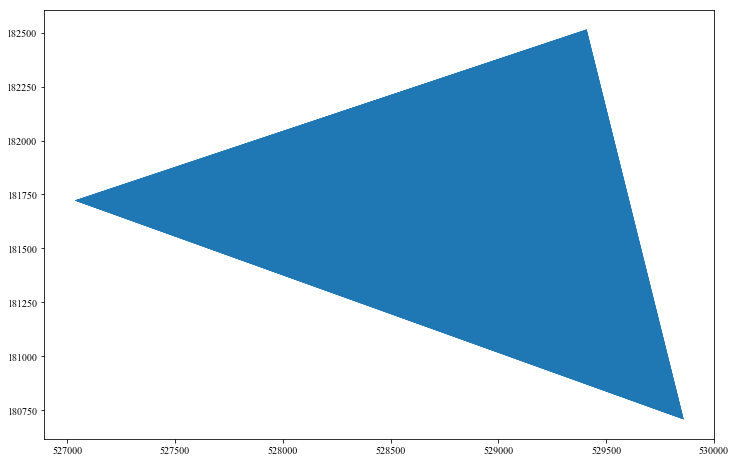

In [85]:
GeoDataFrame(index[i]).rename(columns={0:'geometry'}).plot()

In [97]:
from shapely.strtree import STRtree

In [98]:
str_index = index

In [101]:
for time, geom in str_index.items(): 
    str_tree = STRtree(geom)
    str_index[time] = str_tree


In [143]:
txts = []


for filename in os.listdir(directory): # Iterate over each decomposition domain
    txt = pd.read_csv(directory+'/'+filename, skiprows=1, names=['lon','lat','time']) # read decomp
    results = []
    for x,y in zip(txt['lon'],txt['lat']):   
        result = str_tree.query(shapely.geometry.Point(x,y))
        if result:
            results.append(True)
        else:
            results.append(False)
    txt['Intersect'] = results
    txts.append(txt)
        
        

In [148]:
intersects = pd.concat(txts)
print(len(intersects))
intersects = intersects.loc[intersects['Intersect']==True]
print(len(intersects))
intersects

174090
28090


,lon,lat,time,Intersect
11,530154.451055,182214.698963,473.0,True
13,530268.682225,182987.106231,482.0,True
20,530917.016537,182194.678746,501.0,True
27,530160.441701,182289.741649,340.0,True
29,530072.956844,183071.222477,347.0,True
32,530482.569257,181555.565985,376.0,True
36,533186.269840,181623.156859,391.0,True
40,530268.682225,182987.106231,398.0,True
45,531472.428657,183216.087920,413.0,True
47,530237.544198,182923.881332,415.0,True


In [116]:
txt

,lon,lat,time
0,525909.692483,164163.145209,1220.0
1,534603.385498,172287.740967,1244.0
2,529934.502156,175601.844600,1244.0
3,523937.856620,175790.035674,1245.0
4,532064.697689,177181.158054,1264.0
5,523830.411313,174666.935292,1345.0
6,526958.086072,174914.529139,1192.0
7,530566.630727,172464.805374,1200.0
8,524484.176058,170499.465538,1260.0
9,527919.932329,175318.599222,1305.0


In [110]:
index

{391.0: <shapely.strtree.STRtree at 0x1a4b721a20>,
 404.0: <shapely.strtree.STRtree at 0x1a5124c4e0>,
 406.0: <shapely.strtree.STRtree at 0x1a4b721eb8>,
 419.0: <shapely.strtree.STRtree at 0x1a4b721780>,
 421.0: <shapely.strtree.STRtree at 0x1a4b721e48>,
 453.0: <shapely.strtree.STRtree at 0x1a4b721860>,
 455.0: <shapely.strtree.STRtree at 0x1a4b721be0>,
 458.0: <shapely.strtree.STRtree at 0x1a4b721320>,
 472.0: <shapely.strtree.STRtree at 0x1a4b721f60>,
 473.0: <shapely.strtree.STRtree at 0x1a4b7212e8>,
 480.0: <shapely.strtree.STRtree at 0x1a4b721a90>,
 482.0: <shapely.strtree.STRtree at 0x1a4b721128>,
 483.0: <shapely.strtree.STRtree at 0x1a4b721198>,
 486.0: <shapely.strtree.STRtree at 0x1a4b721278>,
 491.0: <shapely.strtree.STRtree at 0x1a4b721240>,
 492.0: <shapely.strtree.STRtree at 0x1a4b721ba8>,
 493.0: <shapely.strtree.STRtree at 0x1a4b721358>,
 500.0: <shapely.strtree.STRtree at 0x1a4b721518>,
 501.0: <shapely.strtree.STRtree at 0x1a4b721c88>,
 504.0: <shapely.strtree.STRtre

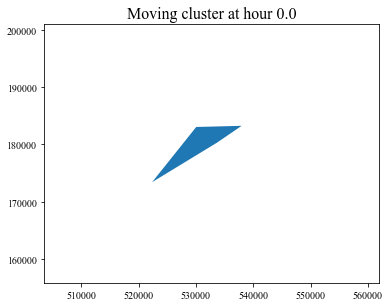

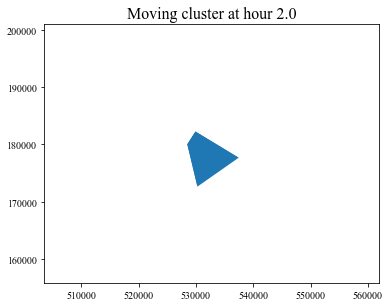

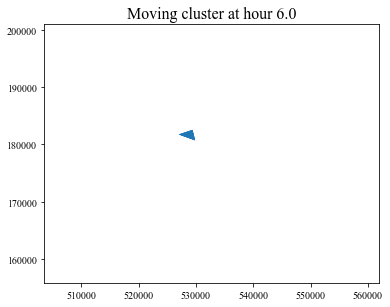

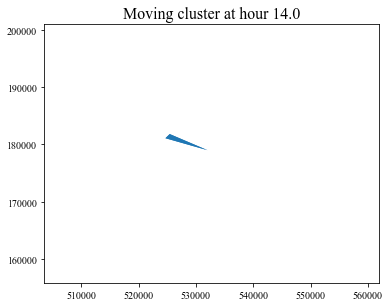

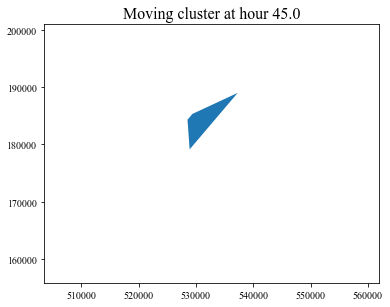

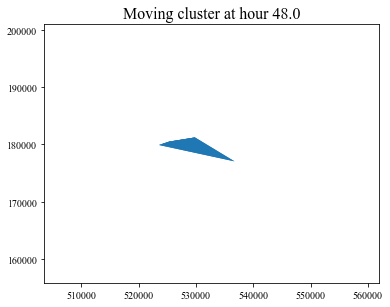

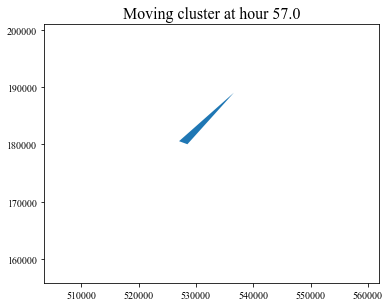

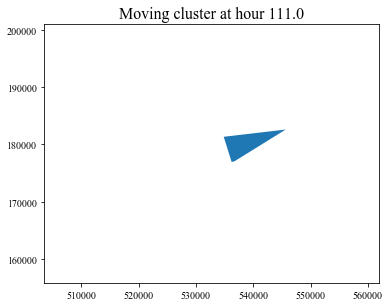

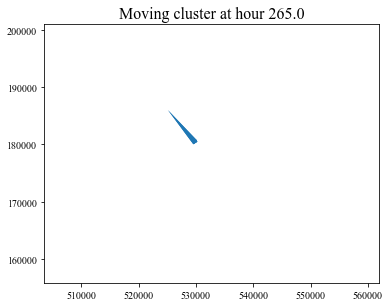

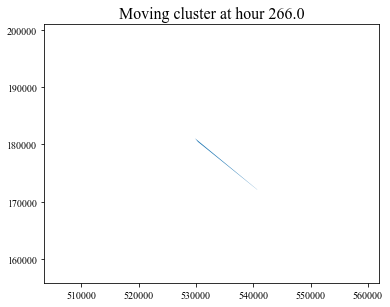

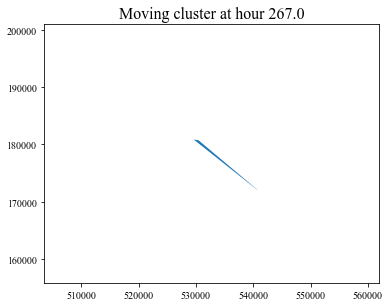

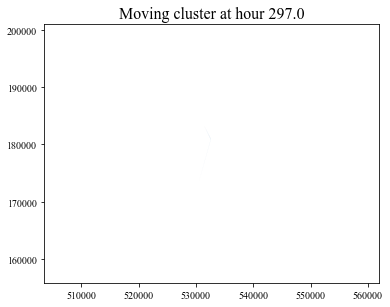

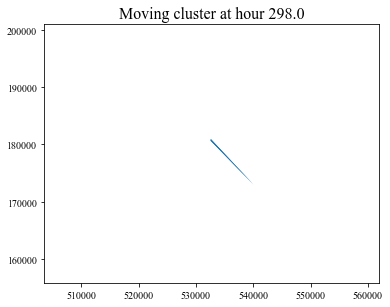

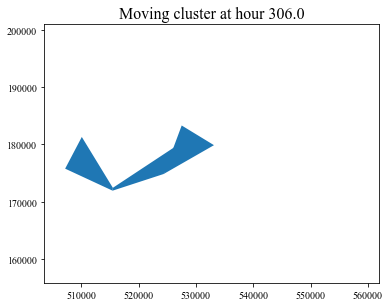

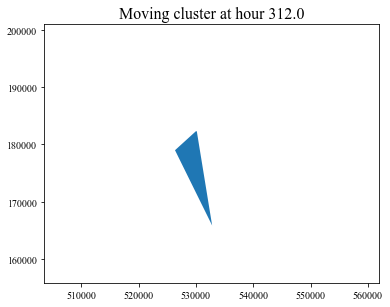

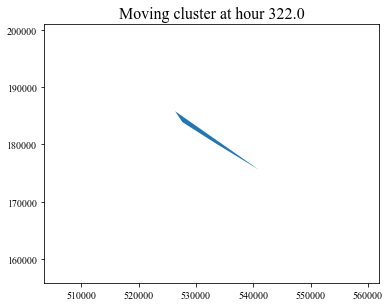

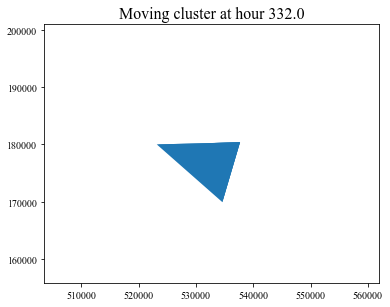

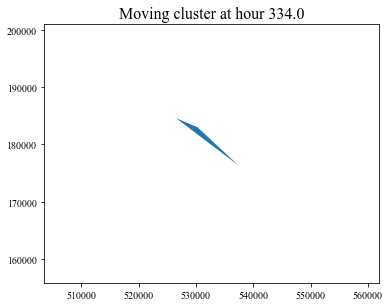

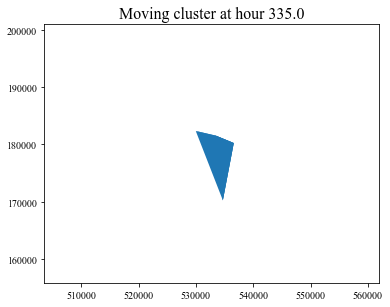

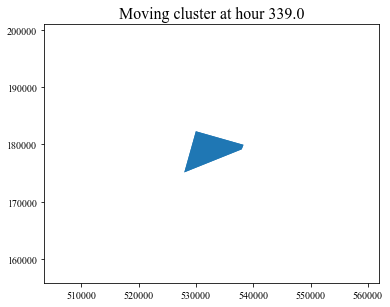

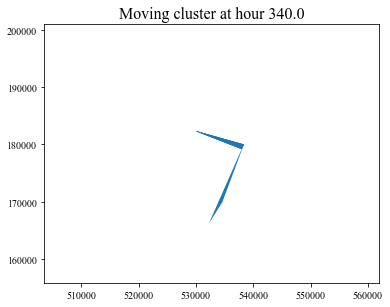

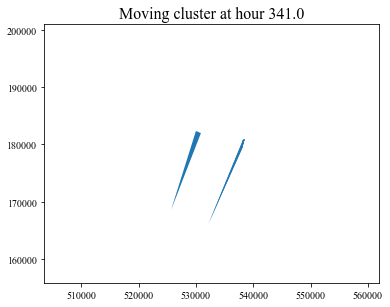

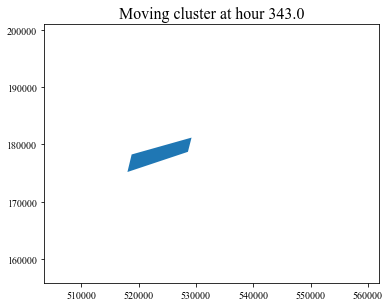

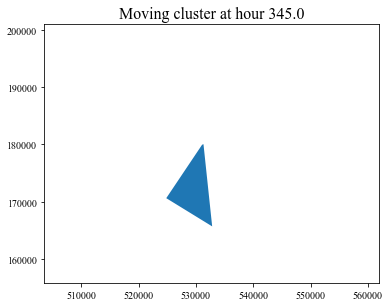

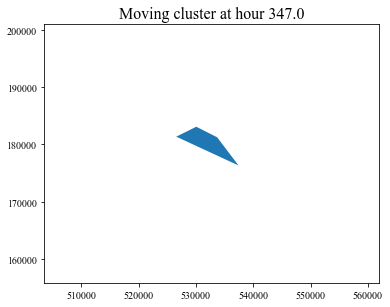

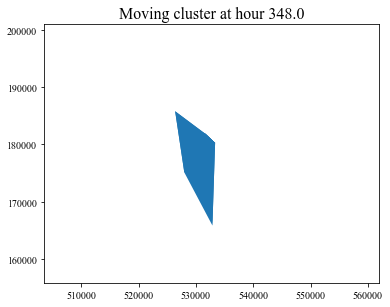

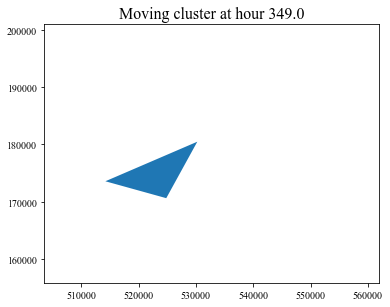

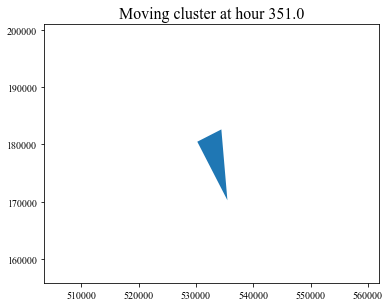

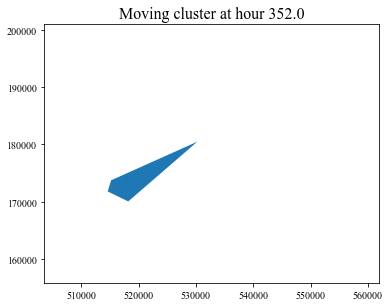

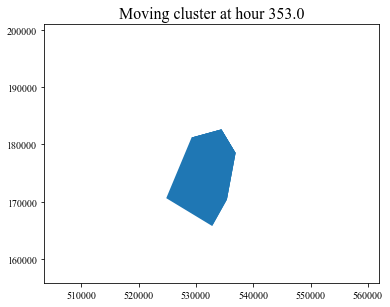

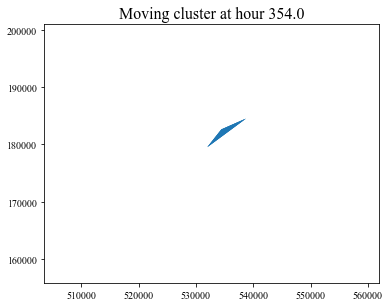

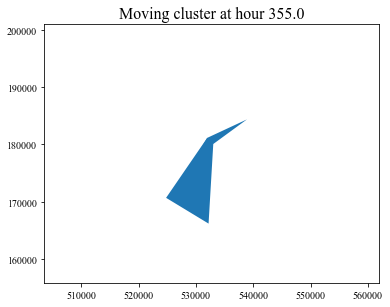

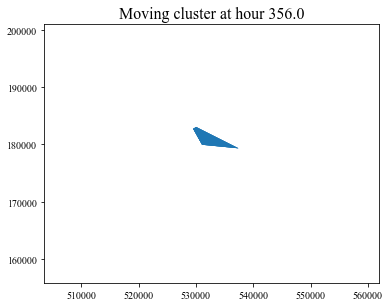

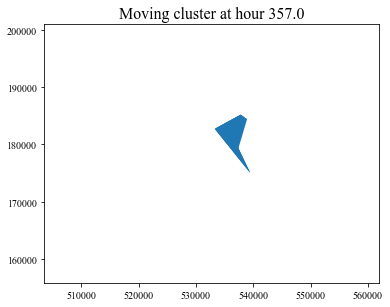

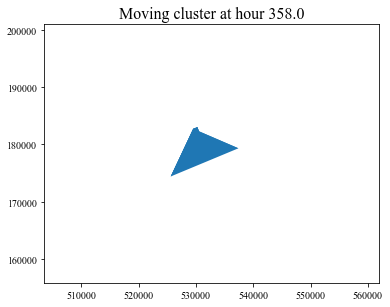

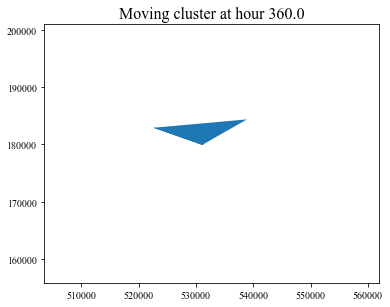

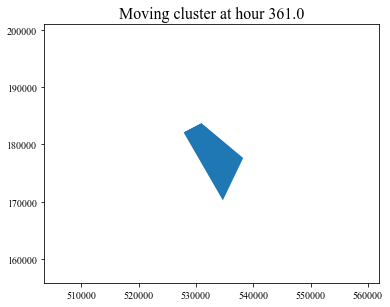

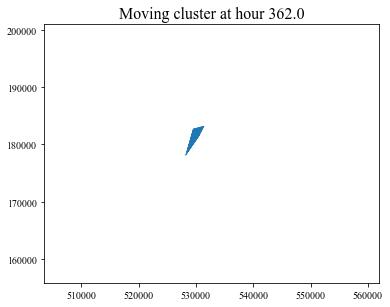

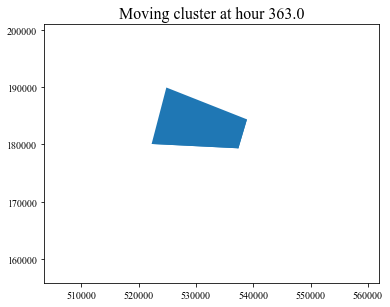

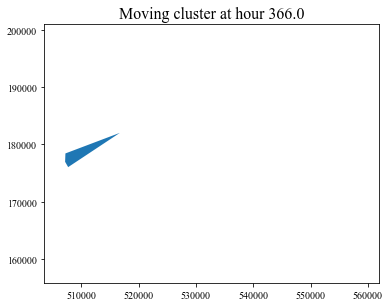

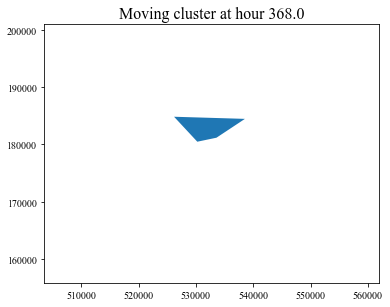

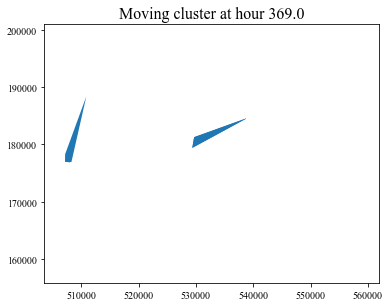

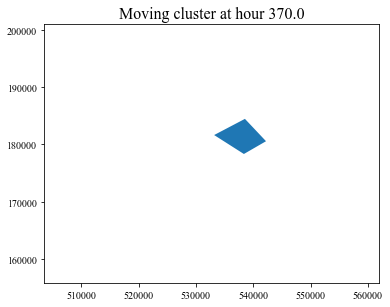

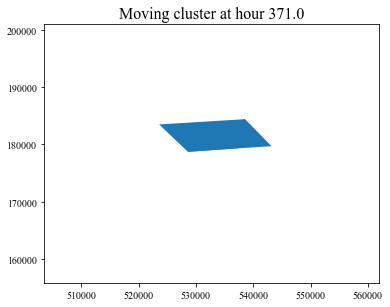

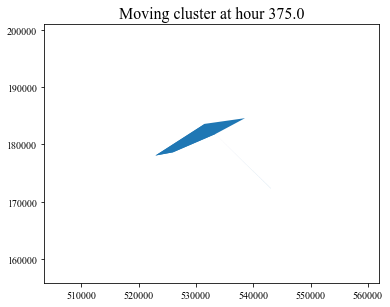

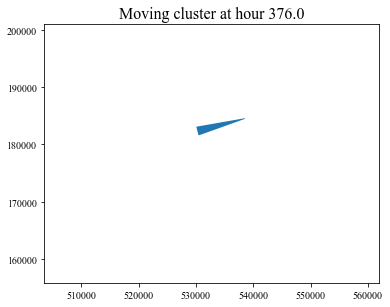

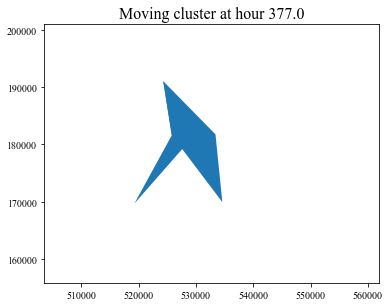

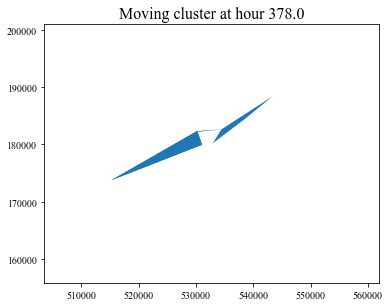

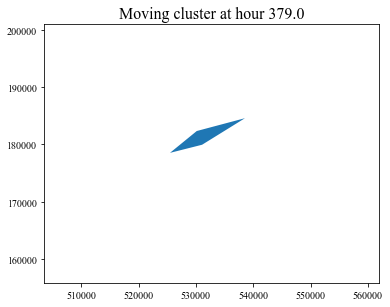

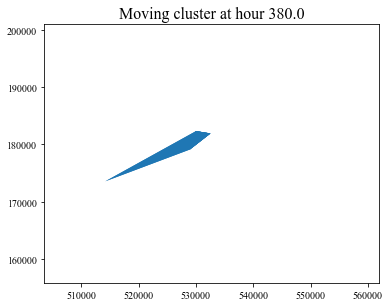

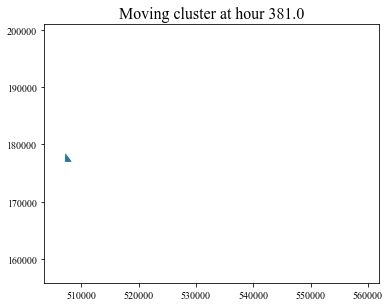

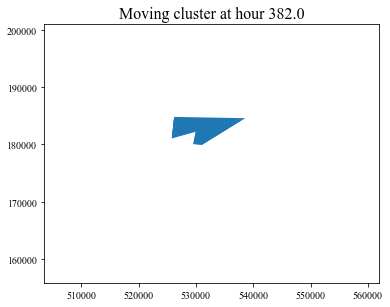

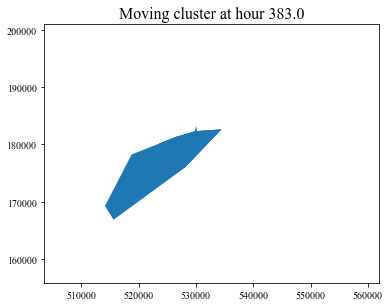

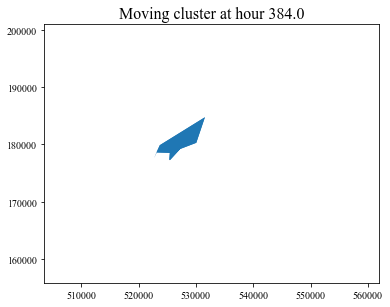

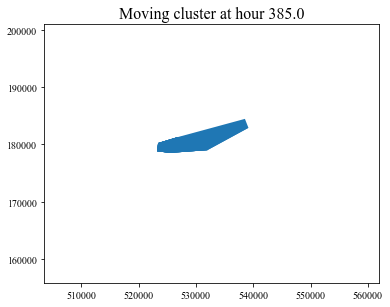

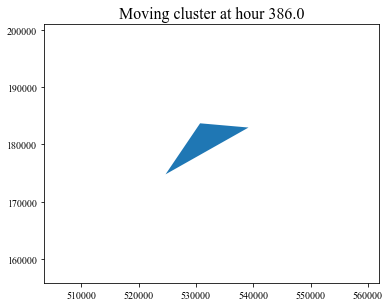

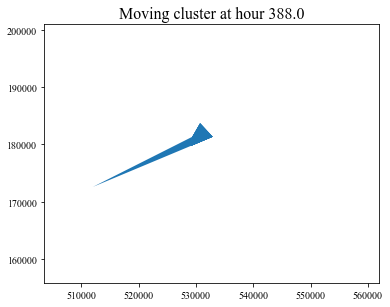

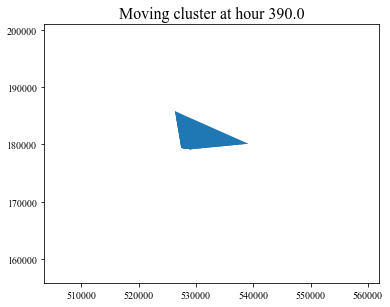

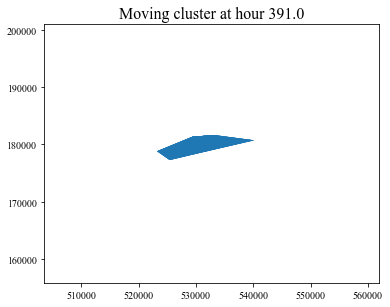

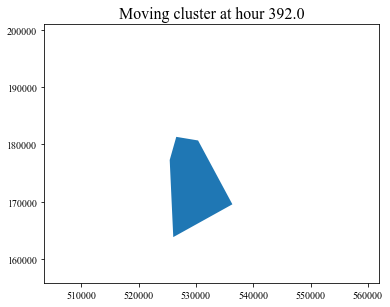

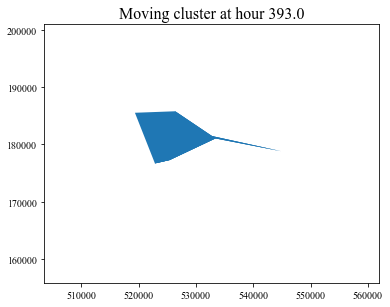

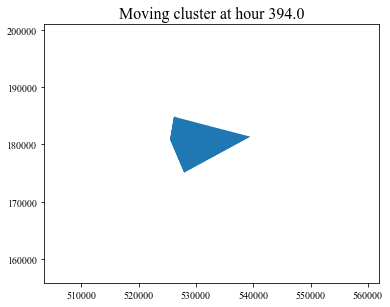

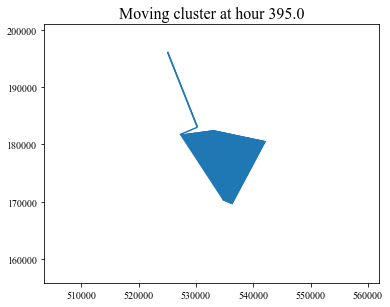

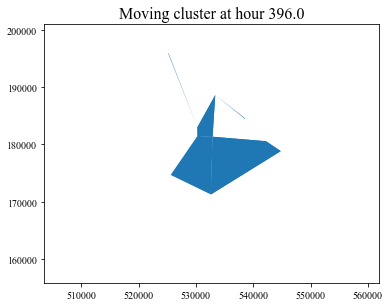

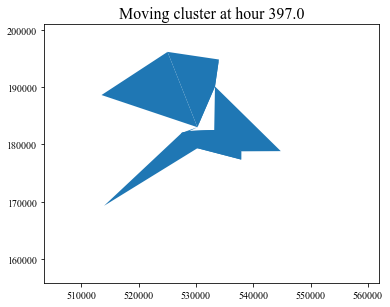

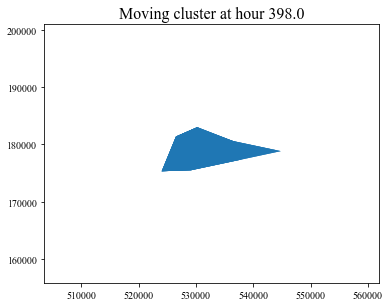

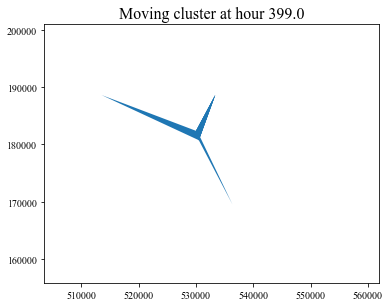

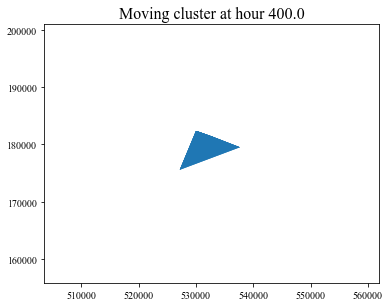

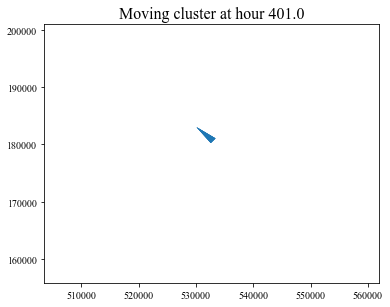

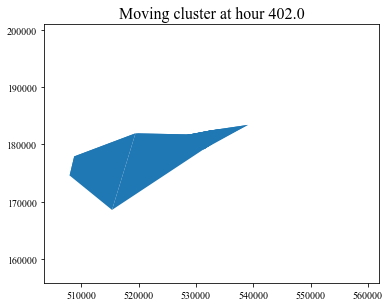

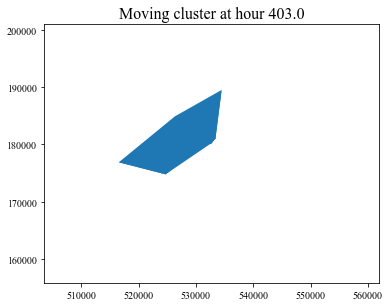

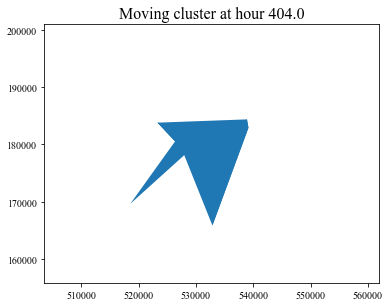

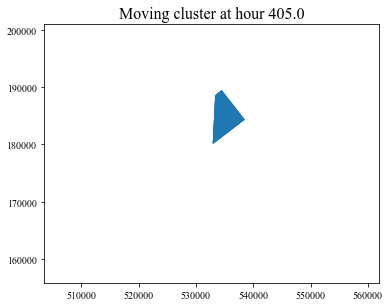

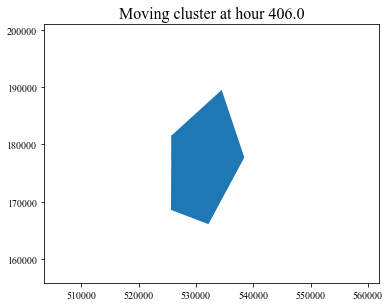

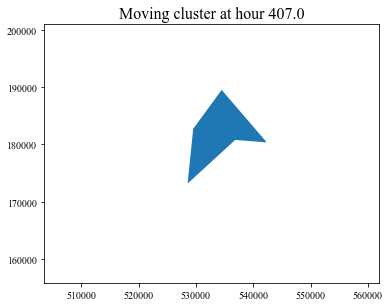

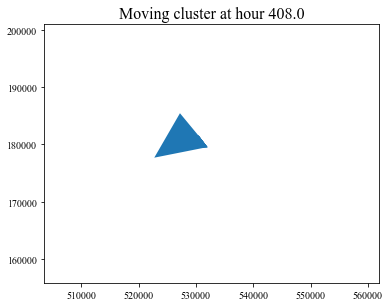

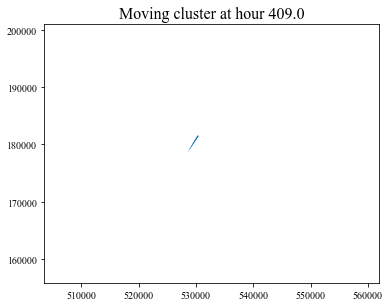

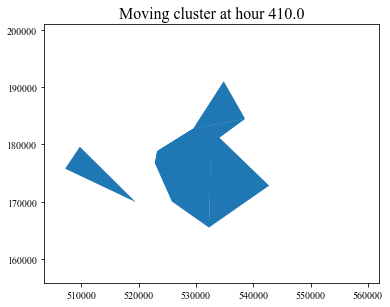

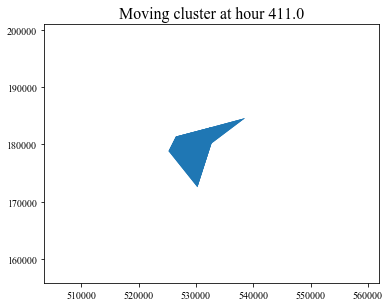

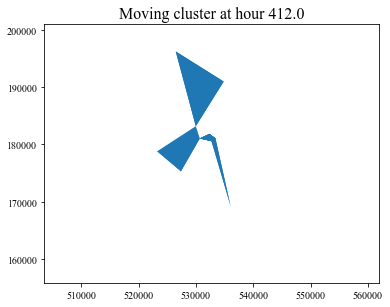

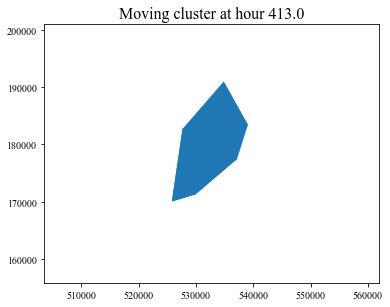

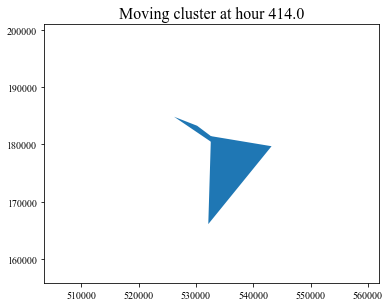

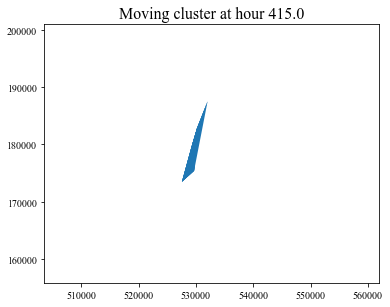

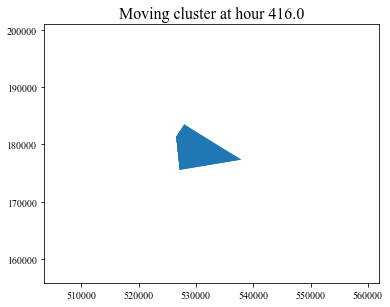

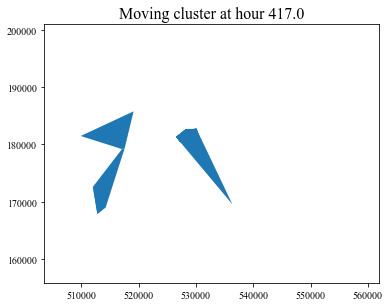

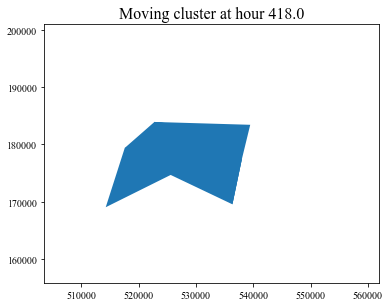

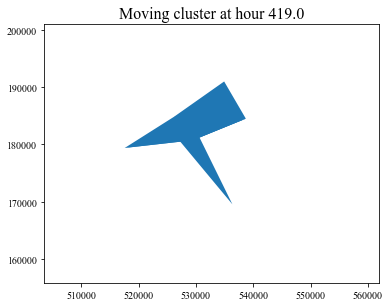

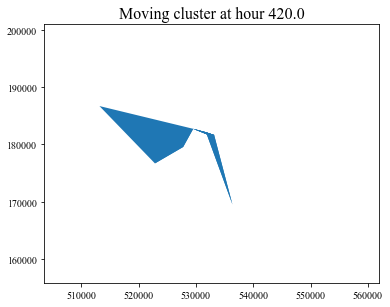

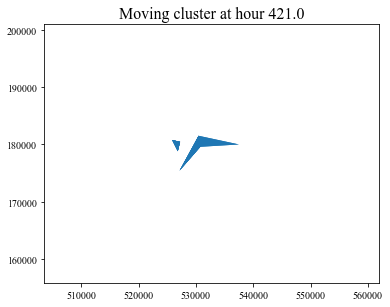

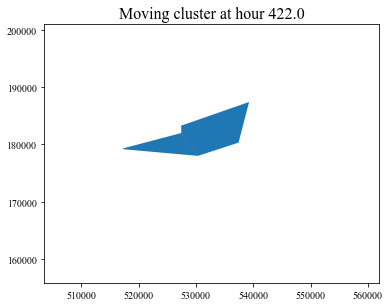

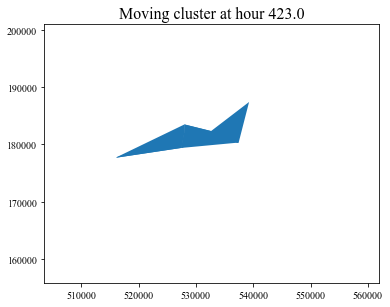

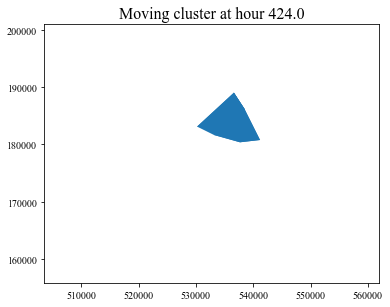

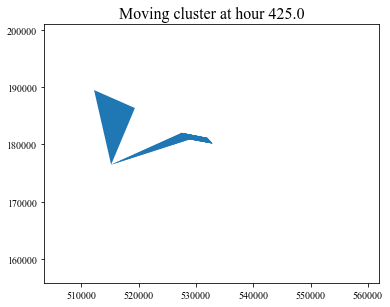

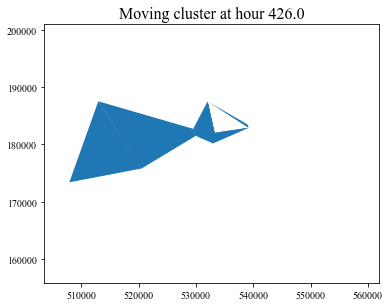

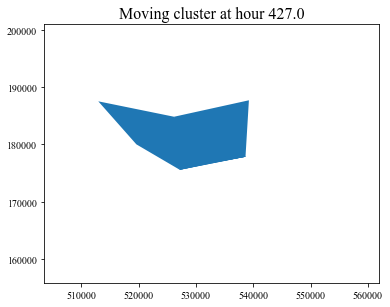

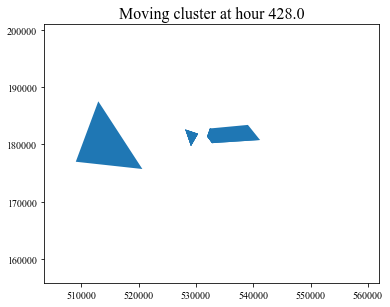

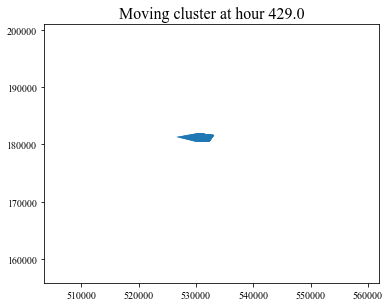

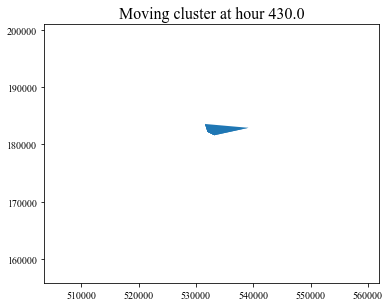

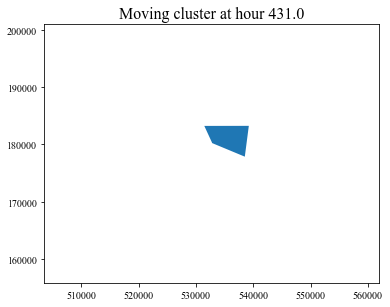

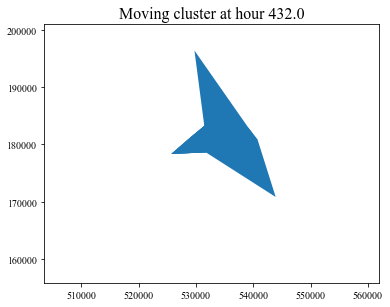

In [93]:
for i in pd.Series(moving_frame_t).sort_values().unique()[0:100]:
    ax = GeoDataFrame(index[i]).rename(columns={0:'geometry'}).plot()
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_title('Moving cluster at hour {}'.format(i), fontdict={'fontsize': 16, 'fontweight': 'medium'})
    

In [134]:
str_index

{391.0: <shapely.strtree.STRtree at 0x1a4b721a20>,
 404.0: <shapely.strtree.STRtree at 0x1a5124c4e0>,
 406.0: <shapely.strtree.STRtree at 0x1a4b721eb8>,
 419.0: <shapely.strtree.STRtree at 0x1a4b721780>,
 421.0: <shapely.strtree.STRtree at 0x1a4b721e48>,
 453.0: <shapely.strtree.STRtree at 0x1a4b721860>,
 455.0: <shapely.strtree.STRtree at 0x1a4b721be0>,
 458.0: <shapely.strtree.STRtree at 0x1a4b721320>,
 472.0: <shapely.strtree.STRtree at 0x1a4b721f60>,
 473.0: <shapely.strtree.STRtree at 0x1a4b7212e8>,
 480.0: <shapely.strtree.STRtree at 0x1a4b721a90>,
 482.0: <shapely.strtree.STRtree at 0x1a4b721128>,
 483.0: <shapely.strtree.STRtree at 0x1a4b721198>,
 486.0: <shapely.strtree.STRtree at 0x1a4b721278>,
 491.0: <shapely.strtree.STRtree at 0x1a4b721240>,
 492.0: <shapely.strtree.STRtree at 0x1a4b721ba8>,
 493.0: <shapely.strtree.STRtree at 0x1a4b721358>,
 500.0: <shapely.strtree.STRtree at 0x1a4b721518>,
 501.0: <shapely.strtree.STRtree at 0x1a4b721c88>,
 504.0: <shapely.strtree.STRtre

In [ ]:
ax = moving_clusters.loc[moving_clusters['time']==time].plot()

ax.set

In [56]:
lookup = {}
lookup[moving_frame_t[0]] = [moving_frames[0]]+[moving_frames[1]]

In [82]:
moving_clusters = GeoDataFrame(moving_frames).rename(columns={0:'geometry'})

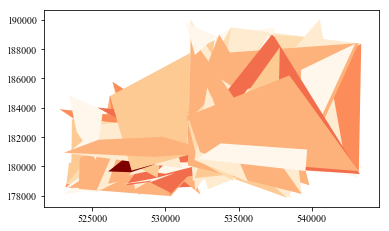

In [86]:
moving_clusters.plot('nps', cmap='OrRd')

In [83]:
xmin, ymin, xmax, ymax = moving_clusters.total_bounds
moving_clusters['time'] = moving_frame_t
moving_clusters['nps'] = moving_cluster_nps
moving_clusters = moving_clusters.sort_values(by='time')
for time in moving_clusters.time.unique():
    ax = moving_clusters.loc[moving_clusters['time']==time].plot()
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_title('Moving cluster at hour {}'.format(time), fontdict={'fontsize': 16, 'fontweight': 'medium'})
    


In [ ]:
moving_clusters

In [ ]:
domain_quadrat.plot?

In [ ]:
txt = txt.sort_values(by='time')
txt['framerate'] = txt.time.shift(1)
frame_rate = txt[['time','framerate']].diff().framerate.mean()
txt['framerate'] = (txt.framerate / frame_rate).fillna(method='backfill').astype(int)
txt.time = txt.framerate * frame_rate

In [ ]:
def graph_run_times(times):
    

In [ ]:
import geopandas as gpd
bb = gpd.read_file('/Users/GeorgePyne/Documents/Geography/2nd Year/Spatial Analysis/5SSG2060_CW1_1531870/data/LDN-LSOAs/LDN-LSOAs.shp')
bb = bb['geometry']
bb.crs = {'init': 'epsg:27700'}
bb = bb.to_crs(epsg=3857)
xmin, ymin, xmax, ymax = bb.total_bounds

In [ ]:
moving_clusters['minutes'] = moving_clusters.time * 30
moving_clusters['datetime'] = moving_clusters.minutes.apply(lambda x: ts + timedelta(minutes=x))
moving_clusters = moving_clusters.sort_values(by='time', ascending=True)
moving_clusters.crs = {'init': 'epsg:27700'}
moving_clusters = moving_clusters.to_crs(epsg=3857)
for time in moving_clusters.time.unique():
    ax = moving_clusters.loc[moving_clusters['time']==time].plot(cmap='OrRd')
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_axis_off()
    add_basemap(ax, zoom=13, url=ctx.sources.ST_TONER_LITE)
#     plt.show()

In [ ]:
moving_clusters = GeoDataFrame(moving_frames).rename(columns={0:'geometry'})
moving_clusters['time'] = moving_frame_t
moving_clusters.time.unique()

In [ ]:
LISA_markov_diagnostics(lm_list)

In [ ]:

def LISA_markov_diagnostics(lm_list):
    
    
    for lm in lm_list:
#         lm_moves = pd.DataFrame({"Transitions":lm.transitions.flatten(), "Expected":lm.expected_t.flatten()}) 
#         lm_moves['Transitions'] = lm_moves['Transitions'].astype(int)
#         lm_moves.index = ["HH-HH","HH-LH","HH-LL","HH-HL", # Make index 16 possible move types
#                   "LH-HH","LH-LH","LH-LL","LH-HL",
#                   "LL-HH","LL-LH","LL-LL","LL-HL",
#                   "HL-HH","HL-LH","HL-LL","HL-HL"]
#         lm_moves['Residuals'] = lm_moves.Transitions - lm_moves.Expected # Calculate difference of observed - expected
#         print('Sum of LM transitions:')
#         print(sum([lm_moves['Residuals'][0], lm_moves['Residuals'][3],lm_moves['Residuals'][8],lm_moves['Residuals'][15]]))
        
        print("Chi2: %8.3f, p: %5.2f, dof: %d" % lm.chi_2)
#         ax = sns.heatmap(np.matrix([lm_moves.Transitions[:4].values,\
#         lm_moves.Transitions[4:8].values,\
#         lm_moves.Transitions[8:12].values,\
#         lm_moves.Transitions[12:].values]), cmap='Purples', 
#                     annot=True, annot_kws={'size':14}, cbar_kws={'label':"LISA Markov observed transitions"})
#         ax.figure.axes[-1].yaxis.label.set_size(18)
#         ax.figure.axes[-1].yaxis.label.set_size(18)
#         ax.set_yticklabels(labels=['HH', 'LH', 'LL', 'HL'], size=18);
#         ax.set_xticklabels(labels=['HH', 'LH', 'LL', 'HL'], size=18);
#         plt.ylabel("Transition from:", size=18)
#         plt.xlabel("Transition to:", size=18,);
#         plt.show();

#         ax = sns.heatmap(np.matrix([lm_moves.Residuals[:4].values,\
#         lm_moves.Residuals[4:8].values,\
#         lm_moves.Residuals[8:12].values,\
#         lm_moves.Residuals[12:].values]), cmap='coolwarm', 
#                     annot=True, annot_kws={'size':14}, cbar_kws={'label':"LISA Markov observed – expected transitions"})
#         ax.figure.axes[-1].yaxis.label.set_size(18)
#         ax.set_yticklabels(labels=['HH', 'LH', 'LL', 'HL'], size=18);
#         ax.set_xticklabels(labels=['HH', 'LH', 'LL', 'HL'], size=18);
#         plt.ylabel("Transition from:", size=18)
#         plt.xlabel("Transition to:", size=18);
#         plt.show();
        
        

In [39]:
dic = {}
numbers = [1,2,3,3,4,5,5,6,7,8]
letters = ['a','b','c','d','e','f','g','h','i','j']



    





In [ ]:
moving_clusters = GeoDataFrame(cluster_spots).rename(columns={0:'geometry'})
moving_clusters['hour'] = cluster_time
moving_clusters['geom_type'] = moving_clusters.geometry.apply(lambda x: type(x))
moving_clusters = moving_clusters.loc[moving_clusters['geom_type']==type(test)][['hour','geometry']]
for hour in moving_clusters.hour.unique():
    moving_clusters.loc[moving_clusters['hour']==hour].to_file('/Users/GeorgePyne/Desktop/shptest/{}hourclustertest.shp'.format(str(hour)), driver='ESRI Shapefile')

In [ ]:
xmin,ymin,xmax,ymax = gdf_points.total_bounds # Get point bounds
height = (xmax-xmin)/ 6 # Set grid resolution
grid = glt.make_grid(gdf_points,height, False) # Create unclipped grid
grid['counts'] = grid.geometry.apply(lambda x: pip_count(gdf_points,x)) # Aggregate points to grid